# 21 June (!) Check accuracy on Petar's annotations

In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import re
# import pysam
import scipy.stats as stats

What do I need to do? 

1. Read in the annotations (.gff3 file) 
2. Turn the annotations into a feature df (add sequence, format it correctly, etc. This is gff_to_feature_df()
3. Feed that into miRge
4. Run miRge carefully
5. train classifier on the dataset_15 dataframe that is output from that miRge run (with features) 
6. check accuracy of that classifier. 

In [121]:
pdf = pd.read_csv('proxy_feature_df_stable_13_June.tsv', sep='\t')

lol you don't have to look for messenger RNA annotations--it's called the exome! Just don't bridge a splice site.

In [113]:
def reverse_complement(sequence):
    pairs = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
    new_seq = []
    for base in sequence[::-1]:
        new_seq.append(pairs[base])
    return ''.join(new_seq)

def lookup_in_hg38(row, hg38):    
    mirna_region = row['seqname'] + ':' + str(int(row['start'])) + '-' + str(int(row['end']))
    try:
        # don't substitute U! 
        if row['strand']== '+':
            miRNA_seq = re.sub('T', 'T', hg38.fetch(region=mirna_region))
        else:
            miRNA_seq = reverse_complement(re.sub('T', 'T', hg38.fetch(region=mirna_region)))
        row['sequence'] = miRNA_seq
    except:
        row['sequence'] = None
    return row

In [514]:
def gff_to_feature_df(gff, hg38, example_feature_df):
    # gff should be pre-filtered to just the species you seek! 
    # gff = pd.read_csv(gff, sep='\t', comment='#', header=None, names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    gff = gff.apply(extract_names, axis=1)
    df = gff[['seqname', 'start', 'end', 'clusterName', 'strand']]
    df = df.apply(lookup_in_hg38, hg38=hg38, axis=1)
    for col in example_feature_df.columns:
        if len(set(example_feature_df[col]))== 1:
            df[col] = example_feature_df[col].values[0]
        elif 'Seq' in col:
            df[col] = df['sequence'] 
    df = df.rename(columns={'seqname':'chr', 'start':'startPos', 'end': 'endPos'}).drop(['strand', 'sequence'], axis=1)
    df = df[example_feature_df.columns]
    return df

In [468]:
def parse_attribute(row):
    try:
        row['type'] = re.search('(?<=type=)[^;]*', row['attributes']).group(0)
        row['name'] = re.search('(?<=Name=)[^;]*', row['attributes']).group(0)
    except:
        print(row['attributes'])
        row['type'] = None
        row['name'] = None
    return row

In [398]:
edf = pd.read_csv('../small_rna_data/proxy_feature_m_mi_RNA_df_22_June.tsv', sep='\t')

In [72]:
hg38 = pysam.Fastafile('hg38/GRCh38.d1.vd1.fa')

In [487]:
small_rnas_train_full = pd.read_csv('../small_rna_data/smallRNA_train.gff3', sep='\t', comment='#', header=None, 
                                    names=['seqname', 'source', 'feature_type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])


miRGeneDB_gff = small_rnas_train_full[small_rnas_train_full['attributes'].str.contains('MirGeneDB')].apply(parse_attribute, axis=1)

/Users/jfernand/opt/anaconda3/envs/mirge-dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [488]:
miRGeneDB_gff = miRGeneDB_gff[miRGeneDB_gff['type'] == 'miRNA']

In [489]:
miRGene_DB_gff_no_dup = miRGeneDB_gff[miRGeneDB_gff.index.isin(miRGeneDB_gff['name'].drop_duplicates().index)]

In [529]:
mirGene_features = gff_to_feature_df(miRGene_DB_gff_no_dup, hg38, edf)

In [530]:
def adjust_length(row, length): 
    try:
        row['miRNA_start'] = stats.randint(row['start'], row['end'] - length).rvs(random_state=1)
        row['miRNA_end'] = row['miRNA_start'] + length
    except:
        row['miRNA_start'] = float('Nan')
        row['miRNA_end'] = float('Nan')    
    return row

def make_mRNA_feature_df(small_rna_feature_df, exome_bed, hg38):
    length_dfs = []
    small_rna_feature_df['length'] = small_rna_feature_df['endPos'].astype(int) - small_rna_feature_df['startPos'].astype(int)
    exome_bed = exome_bed[~exome_bed['chr'].str.contains('_')]
    for length in set(small_rna_feature_df['length']):
        df = exome_bed.sample(sum(small_rna_feature_df['length'] == length), random_state=1)
        df = df.apply(adjust_length, length=length, axis=1)
        df['strand'] = '+'
        df = df[~df['miRNA_start'].isna()]
        df = df.apply(add_clusterName, axis=1)
        length_dfs.append(df)
    df = pd.concat(length_dfs).drop(['start', 'end'], axis=1).rename(columns={'miRNA_start':'start', 'miRNA_end':'end', 'chr':'seqname'})
    df = df[~df['start'].isna()].apply(lookup_in_hg38, hg38=hg38, axis=1)
    for col in small_rna_feature_df.columns:
        if len(set(small_rna_feature_df[col]))== 1:
            df[col] = small_rna_feature_df[col].values[0]
        elif 'Seq' in col:
            df[col] = df['sequence'] 
    df = df.rename(columns={'seqname':'chr', 'start':'startPos', 'end': 'endPos'}).drop(['strand', 'sequence', 'length'], axis=1)
    df = df[pdf.columns]
    df['startPos'] = df['startPos'].astype(int)
    df['endPos'] = df['endPos'].astype(int)
    return df

def add_clusterName(row):
    row['clusterName'] = 'mRNA_exome' + ':' + 'exome' + '_' + row['chr'] + '_' + str(row['start']) + '_' + str(row['end']) + ':' + row['chr'] + ':' + str(int(row['miRNA_start'])) + '_' + str(int(row['miRNA_end'])) + '+' 
    return row

In [531]:
exome_bed = pd.read_csv('../small_rna_data/exome.bed', sep='\t', header=None, names=['chr', 'start', 'end'])

exome_bed['length'] = exome_bed['end'] - exome_bed['start'] 

In [532]:
mRNA_df = make_mRNA_feature_df(mirGene_features.copy(), exome_bed, hg38)

In [534]:
proxy_feature_df_June_23 = pd.concat([mirGene_features, mRNA_df])

In [537]:
proxy_feature_df_June_23.to_csv('proxy_feature_df_June_23.tsv', sep='\t', index=None)

# Run miRge... 

In [4]:
feature_df_output = pd.read_csv('output_dir/miRge.2022-06-23_12-48-52/unmapped_tmp/GTEX-1117F-0005-SM-GMJZF.lncRNA_dataset_15_refined_tmp.csv')

In [5]:
feature_df_output.head()

,realMicRNA,realMicRNAName,clusterName,adjustedClusterSeq,clusterSecondSeq,templateSeq,seqCount,readCountSum,exactMatchRatio,headUnstableLength,...,percentage_PairedInMiRNA,hairpin_count,binding_count,interiorLoopCount,apicalLoop_size,stem_length,mFE,count_bindings_in_miRNA,UGU_UGUG_motif,pair_state
0,Null,Null,annotation:URS000012A1DD_9606:chr1:1167124_116...,CATCTTACTGGGCAGCATTGGA,CATCTTACTGGGCAGCATTGGA,CATCTTACTGGGCAGCATTGGA,1000,1000,Null,0,...,0.95,1,32,5,6,32,-40.9,21,No,No
1,Null,Null,annotation:URS00002B452B_9606:chr1:1167160_116...,TAATACTGCCTGGTAATGATGAC,TAATACTGCCTGGTAATGATGAC,TAATACTGCCTGGTAATGATGAC,1000,1000,Null,0,...,0.91,1,34,6,6,34,-43.1,21,No,No
2,Null,Null,annotation:URS000023B77E_9606:chr1:1167878_116...,CATCTTACCGGACAGTGCTGGA,CATCTTACCGGACAGTGCTGGA,CATCTTACCGGACAGTGCTGGA,1000,1000,Null,0,...,0.95,1,32,4,5,32,-45.1,21,No,No
3,Null,Null,annotation:URS00003DB428_9606:chr1:1167916_116...,TAACACTGTCTGGTAACGATGTT,TAACACTGTCTGGTAACGATGTT,TAACACTGTCTGGTAACGATGTT,1000,1000,Null,0,...,0.78,1,32,4,5,32,-45.5,18,No,No
4,Null,Null,annotation:URS000055BBE5_9606:chr1:1169055_116...,TAATACTGTCTGGTAAAACCGT,TAATACTGTCTGGTAAAACCGT,TAATACTGTCTGGTAAAACCGT,1000,1000,Null,0,...,0.77,1,29,3,10,29,-38.8,17,No,No


In [6]:
working_input_to_training = pd.read_csv('SVM_training/my_features.csv')

In [7]:
def add_label(row):
    if 'exome' in row['clusterName']:
        row['realMicRNA'] = -1
    else:
        row['realMicRNA'] = 1
    return row

feature_df_output = feature_df_output.apply(add_label, axis=1)
feature_df_output = feature_df_output[working_input_to_training.columns]

In [8]:
fdf_test = feature_df_output.sample(round(.2 * len(feature_df_output)), random_state=1)

In [9]:
fdf_test

,realMicRNA,realMicRNAName,clusterName,seqCount,readCountSum,exactMatchRatio,headUnstableLength,tailUnstableLength,head_minus3_templateNucleotide,head_minus3_TemplateNucleotide_percentage,...,percentage_PairedInMiRNA,hairpin_count,binding_count,interiorLoopCount,apicalLoop_size,stem_length,mFE,count_bindings_in_miRNA,UGU_UGUG_motif,pair_state
1263,-1,Null,mRNA_exome:exome_chr11_67303529_67312592:chr11...,1000,1000,Null,0,0,A,Null,...,0.45,1,20,4,15,20,-34.1,10,No,No
137,1,Null,annotation:URS000025D232_9606:chr11:72615102_7...,1000,1000,Null,0,0,A,Null,...,0.91,1,33,6,11,33,-44.5,21,No,No
1849,-1,Null,mRNA_exome:exome_chr11_1752754_1763927:chr11:1...,1000,1000,Null,0,0,A,Null,...,0.46,3,10,0,10,10,-9.1,11,No,No
267,1,Null,annotation:URS000019F055_9606:chr14:101032033_...,1000,1000,Null,0,0,A,Null,...,0.77,1,33,7,7,33,-28.1,17,No,No
186,1,Null,annotation:URS000075E54C_9606:chr13:24162431_2...,1000,1000,Null,0,0,A,Null,...,0.82,1,29,6,5,29,-38.3,18,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,Null,annotation:URS000032BD73_9606:chr6:52148988_52...,1000,1000,Null,0,0,A,Null,...,0.82,1,35,7,3,35,-46.1,18,No,No
861,1,Null,annotation:URS000075AA9A_9606:chrX:50008482_50...,1000,1000,Null,0,0,A,Null,...,0.78,1,28,4,9,28,-37.8,18,Yes,No
1338,-1,Null,mRNA_exome:exome_chr5_175478559_175529741:chr5...,1000,1000,Null,0,0,A,Null,...,0.64,2,30,7,5,30,-11.4,14,No,No
1037,-1,Null,mRNA_exome:exome_chr1_18065656_18074411:chr1:1...,1000,1000,Null,0,0,A,Null,...,0.67,1,27,5,6,27,-10.7,14,Yes,No


In [10]:
fdf_test.to_csv('SVM_training/miRGene_mRNA_features_test.csv', index=False)

In [11]:
fdf_train = feature_df_output[~feature_df_output.index.isin(fdf_test.index)]

In [12]:
fdf_train.to_csv('SVM_training/miRGene_mRNA_features_train.csv', index=False)

In [19]:
feature_df_output[feature_df_output['realMicRNA'] == 1]

,realMicRNA,realMicRNAName,clusterName,seqCount,readCountSum,exactMatchRatio,headUnstableLength,tailUnstableLength,head_minus3_templateNucleotide,head_minus3_TemplateNucleotide_percentage,...,percentage_PairedInMiRNA,hairpin_count,binding_count,interiorLoopCount,apicalLoop_size,stem_length,mFE,count_bindings_in_miRNA,UGU_UGUG_motif,pair_state
0,1,Null,annotation:URS000012A1DD_9606:chr1:1167124_116...,1000,1000,Null,0,0,A,Null,...,0.95,1,32,5,6,32,-40.9,21,No,No
1,1,Null,annotation:URS00002B452B_9606:chr1:1167160_116...,1000,1000,Null,0,0,A,Null,...,0.91,1,34,6,6,34,-43.1,21,No,No
2,1,Null,annotation:URS000023B77E_9606:chr1:1167878_116...,1000,1000,Null,0,0,A,Null,...,0.95,1,32,4,5,32,-45.1,21,No,No
3,1,Null,annotation:URS00003DB428_9606:chr1:1167916_116...,1000,1000,Null,0,0,A,Null,...,0.78,1,32,4,5,32,-45.5,18,No,No
4,1,Null,annotation:URS000055BBE5_9606:chr1:1169055_116...,1000,1000,Null,0,0,A,Null,...,0.77,1,29,3,10,29,-38.8,17,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,1,Null,annotation:URS0000EFCCEE_9606:chrX:151959640_1...,1000,1000,Null,0,0,A,Null,...,0.77,1,30,4,11,30,-41.2,17,Yes,No
969,1,Null,annotation:URS0000587A5B_9606:chrX:151959675_1...,1000,1000,Null,0,0,A,Null,...,0.82,1,28,3,11,28,-38.2,18,Yes,No
970,1,Null,annotation:URS0000D523DA_9606:chrX:151959676_1...,1000,1000,Null,0,0,A,Null,...,0.71,1,30,4,11,30,-41.2,17,Yes,No
971,1,Null,annotation:URS0000D52745_9606:chrX:152392229_1...,1000,1000,Null,0,0,A,Null,...,0.87,1,34,4,10,34,-47.8,20,No,No


In [13]:
feature_df_output[working_input_to_training.columns].to_csv('SVM_training/miRGene_mRNA_features.csv', index=False)

Thank heaven!

# 23 June assess accuracy when we split beforehand so we can easily check distributions in the test data

We need to process the test data (convert it to dummy variables, standardize it using the model's standardizer, and get numpy values) before checking accuracy. 

In [20]:
featureListSelected = []
with open('SVM_training/prec_only_no_pair_no_arm_features.txt', 'r') as inf:
    line = inf.readline()
    line = inf.readline()
    while line != '':
        featureListSelected.append((float(line.strip().split('\t')[1]), int(
            line.strip().split('\t')[2]), line.strip().split('\t')[0]))
        line = inf.readline()

data = pd.read_csv('SVM_training/miRGene_mRNA_features_test.csv')
y_test = data.iloc[:, 0].values
data.drop(data.columns[[1, 2]], axis=1, inplace=True)
data = pd.get_dummies(data)
#featureList = data.columns.values.tolist()[1:]

# subselect data with the selected features
totalfeatureList = data.columns.values.tolist()
subIndexList = [totalfeatureList.index(item[2]) for item in featureListSelected]
# Creat a variable for the feature data
data_x_test = data.iloc[:, subIndexList].values

In [21]:
sc, clf, selectFeatureNameList = joblib.load('SVM_training/miRGene_mRNA_train.pkl')

/Users/jfernand/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jfernand/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SVC from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jfernand/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [22]:
X_test_std = sc.transform(data_x_test)

In [23]:
X_test_std.shape

(381, 8)

In [24]:
y_test.shape

(381,)

In [25]:
preds = clf.predict(X_test_std)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          -1       0.95      0.97      0.96       193
           1       0.97      0.95      0.96       188

    accuracy                           0.96       381
   macro avg       0.96      0.96      0.96       381
weighted avg       0.96      0.96      0.96       381



In [64]:
test = pd.read_csv('SVM_training/miRGene_mRNA_features_test.csv')

In [45]:
train_test = pd.read_csv('SVM_training/miRGene_mRNA_features.csv')

In [48]:
features = ['mFE', 'distanceToloop', 'percentage_PairedInMiRNA', 'hairpin_count', 'binding_count', 'interiorLoopCount', 'apicalLoop_size', 'stem_length']

In [57]:
plt.rcParams['font.size'] = 20

In [83]:
len(train_test)

1907

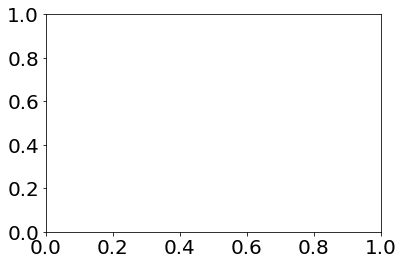

In [114]:
fig, ax = plt.subplots()

In [115]:
ax.get_xlim()

(0.0, 1.0)

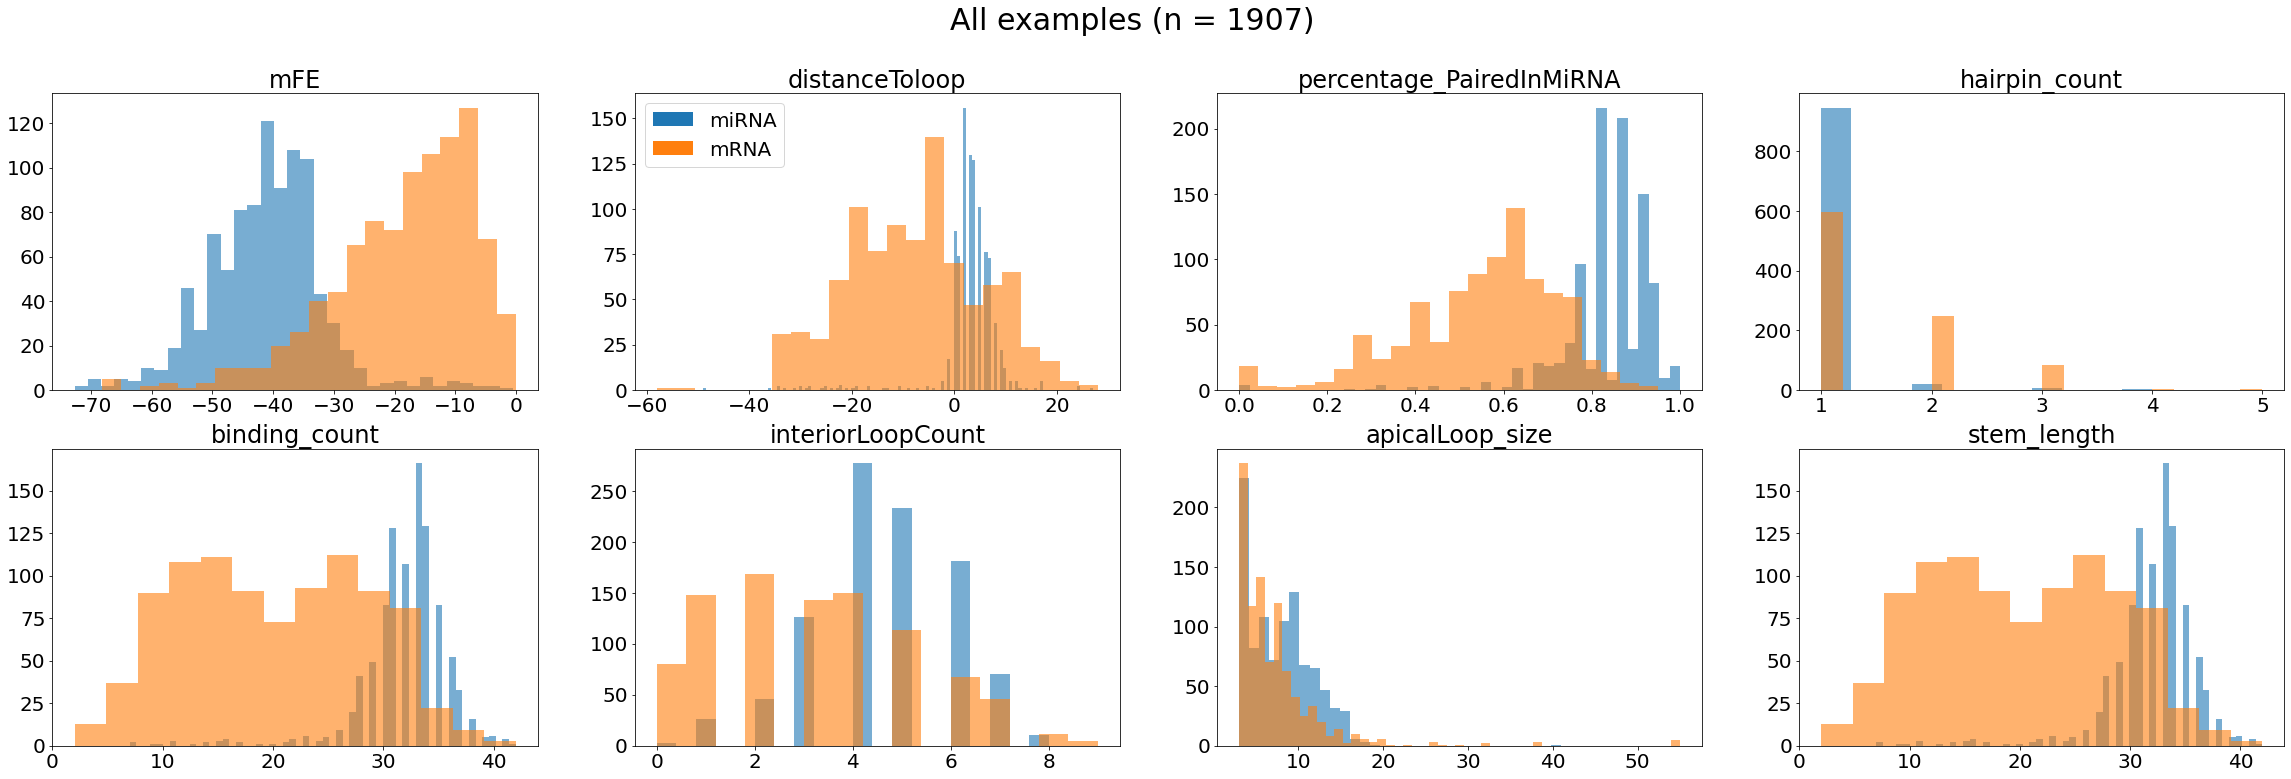

In [127]:
def plot_feature_distributions(df, features, title=None, input_limits=None):
    fig, axs = plt.subplots(2, 4, figsize = (40, 12))
    limits = {}
    for i, ax in enumerate(axs.flatten()):
        df_mi = df[df['realMicRNA'] == 1]
        ax.hist(df_mi[features[i]], bins='auto', label='miRNA', alpha = 0.6)
        df_m = df[df['realMicRNA'] == -1]
        ax.hist(df_m[features[i]], bins='auto', label='mRNA', alpha = 0.6)
        ax.set_title(features[i])
        if i == 1:
            leg = ax.legend()
            for lh in leg.legendHandles: 
                lh.set_alpha(1)

        limits[features[i]] = ax.get_xlim()
        if input_limits is not None:
            ax.set_xlim(input_limits[features[i]])
    if title is not None:
        fig.suptitle(title, size=30)
    return limits
limits = plot_feature_distributions(train_test, features, 'All examples (n = 1907)')

In [120]:
limits

{'mFE': (-76.33, 3.5300000000000002),
 'distanceToloop': (-62.3, 32.3),
 'percentage_PairedInMiRNA': (-0.05, 1.05),
 'hairpin_count': (0.7999999999999998, 5.2),
 'binding_count': (-4.440892098500626e-16, 44.00000000000001),
 'interiorLoopCount': (-0.44999999999999996, 9.449999999999998),
 'apicalLoop_size': (0.40000000000000036, 57.599999999999994),
 'stem_length': (-4.440892098500626e-16, 44.00000000000001)}

In [71]:
correct = test[y_test == preds]
incorrect = test[np.logical_not(y_test==preds)]

{'mFE': (-51.425, 1.9250000000000003),
 'distanceToloop': (-36.35, 15.35),
 'percentage_PairedInMiRNA': (-0.04550000000000002, 0.9555000000000001),
 'hairpin_count': (0.375, 3.1249999999999996),
 'binding_count': (5.549999999999999, 37.45),
 'interiorLoopCount': (-0.3999999999999999, 8.4),
 'apicalLoop_size': (2.3, 17.7),
 'stem_length': (5.549999999999999, 37.45)}

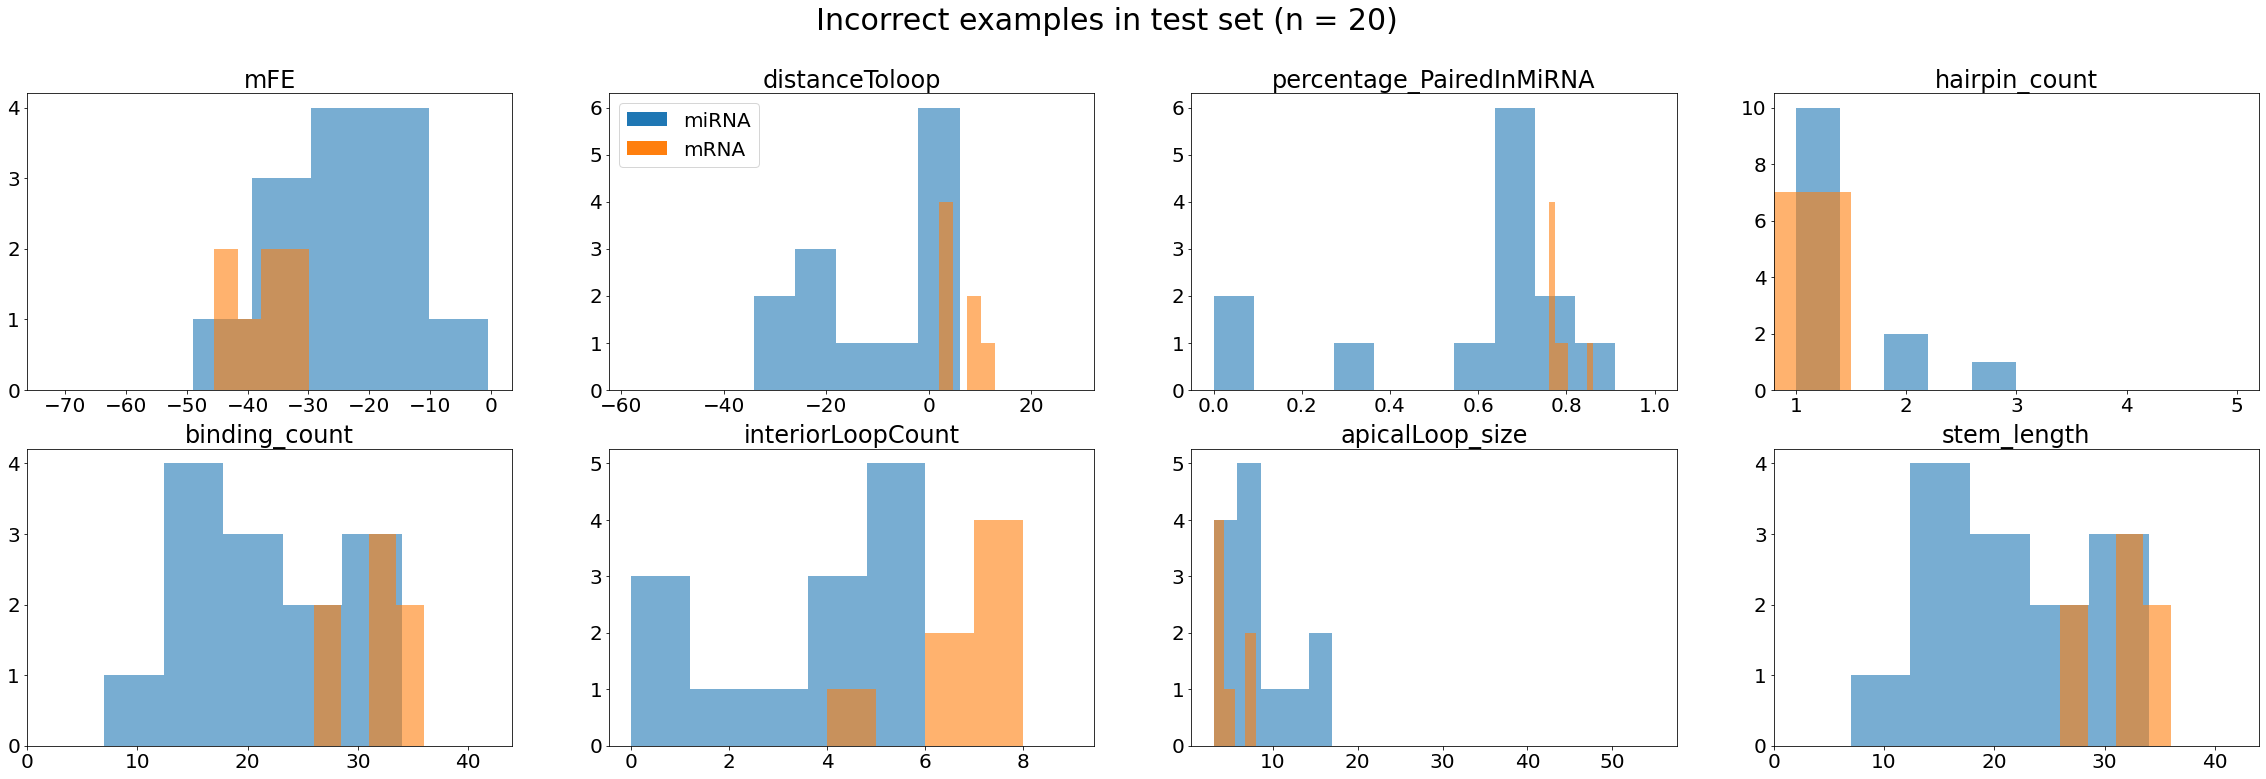

In [128]:
plot_feature_distributions(incorrect, features, "Incorrect examples in test set (n = 20)", limits)

Length distribution, correct vs incorrect miRNAs

In [88]:
row = train_test['clusterName'].values[0]

In [105]:
def get_length(row):
    coords = re.search('[^:]*$', row['clusterName']).group(0)
    start = re.search('[^_]*', coords).group(0)
    end = re.sub('-', '', re.search('(?<=_)[^(+)]*', coords).group(0))
    row['length'] = int(end) - int(start)
    return row
correct = correct.apply(get_length, axis=1)
incorrect = incorrect.apply(get_length, axis=1)

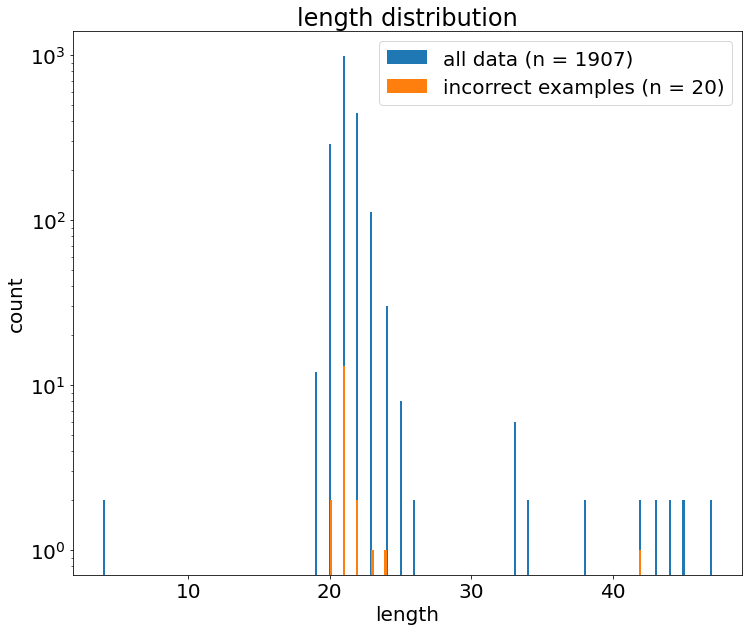

In [112]:
fig, ax = plt.subplots(figsize = (12, 10))
ax.hist(train_test['length'], bins='auto', label='all data (n = 1907)');
ax.hist(incorrect['length'], bins='auto', label='incorrect examples (n = 20)');
ax.legend()
ax.set_xlabel('length')
ax.set_ylabel('count')
ax.set_title('length distribution')
ax.semilogy();

# initial test train split

In [320]:
small_rnas = pd.read_csv('../small_rna_data/smallRNA.gff3', sep='\t', comment='#', header=None, names=['seqname', 'source', 'feature_type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])

In [348]:
test = small_rnas.sample(round(.2 * len(small_rnas)), random_state=1)

In [349]:
test.to_csv('../small_rna_data/final_test_data/smallRNA_test.gff3', sep='\t')

In [350]:
train = small_rnas[~small_rnas.index.isin(test.index)]

In [354]:
train.to_csv('../small_rna_data/smallRNA_train.gff3', sep='\t')

# Side note: I think this is the best way to approach test train split. 
1. Do an 80-20 split immediately upon downloading any data you'll end up using. Don't touch the test data (even put it in a separate folder) until you are writing the manuscript. 
2. Within the training data, do another 80-20 split. Do this at the level of the data frame, not using scipy.test_train_split. Why? scipy.test_train_split splits on numpy arrays, so after you test the model you have to map the test examples back to your data frame if you want to explore distributions and see what examples the model is classifying incorrectly.